# **Inteligencia Artificial y Aprendizaje Automático**
## **Maestría en Inteligencia Artificial Aplicada**
### **Dr Luis Eduardo Falcón Morales**
### **Tecnológico de Monterrey**
## **Actividad Individual Semana 9: Pronósticos con Series de Tiempo**


#### **Nombre:** Marcelo Ismael López Verdugo
#### **Matrícula:**  A00959089

In [95]:
## ++++++++++ Incluye todas las celdas y líneas de código que requieras +++++++++++++++++++++++++
#Librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.metrics import mean_squared_error
import math

from prophet import Prophet
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import keras
from keras import Sequential
from keras import layers
from keras.layers import LSTM, Dense

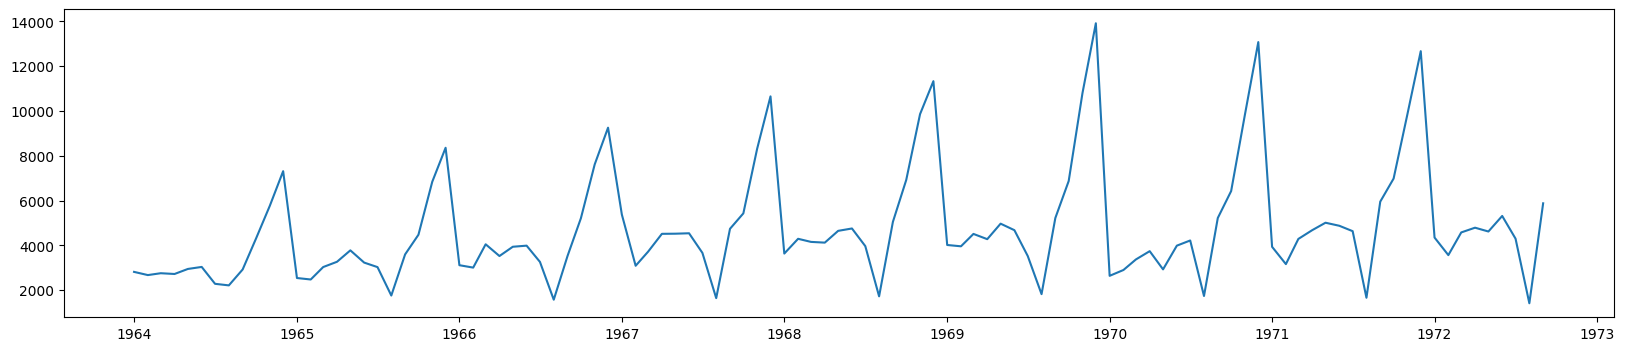

In [27]:
# Carga inicial de datos
df=pd.read_csv('monthly_champagne_sales.csv')
#A formato de fecha
df['Month']= pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
# Colocar frecuencia
df.index.freq = 'MS'
#print(df.index)

plt.figure(figsize=(20,4))
plt.plot(df)

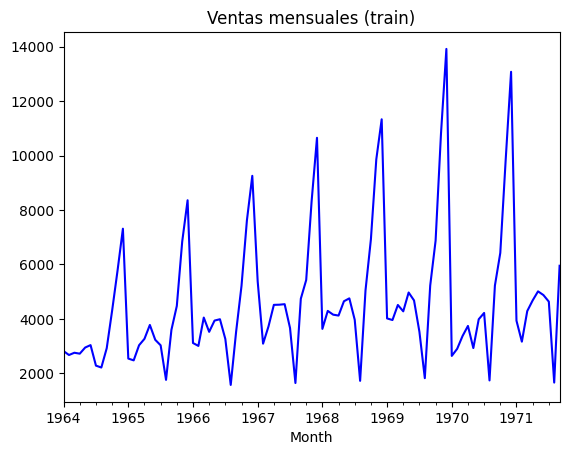

<Figure size 2000x400 with 0 Axes>

In [83]:
#Partición de entrenamiento y test
train = df.iloc[0:-12,:]
test = df.iloc[-12:,:] 

#Étude: Debería usar train test??? 

train['Sales'].plot(title='Ventas mensuales (train)', style='-b')
plt.figure(figsize=(20,4))
plt.show()

## Modelo Ingenuo
Sirve como baseline para comparar contra otros modelos predictivos

>Esperado-real = 6981, Predicción = 5951.000
>Esperado-real = 9851, Predicción = 6981.000
>Esperado-real = 12670, Predicción = 9851.000
>Esperado-real = 4348, Predicción = 12670.000
>Esperado-real = 3564, Predicción = 4348.000
>Esperado-real = 4577, Predicción = 3564.000
>Esperado-real = 4788, Predicción = 4577.000
>Esperado-real = 4618, Predicción = 4788.000
>Esperado-real = 5312, Predicción = 4618.000
>Esperado-real = 4298, Predicción = 5312.000
>Esperado-real = 1413, Predicción = 4298.000
>Esperado-real = 5877, Predicción = 1413.000

Error-Modelo-Naive: RMSE: 3135.480


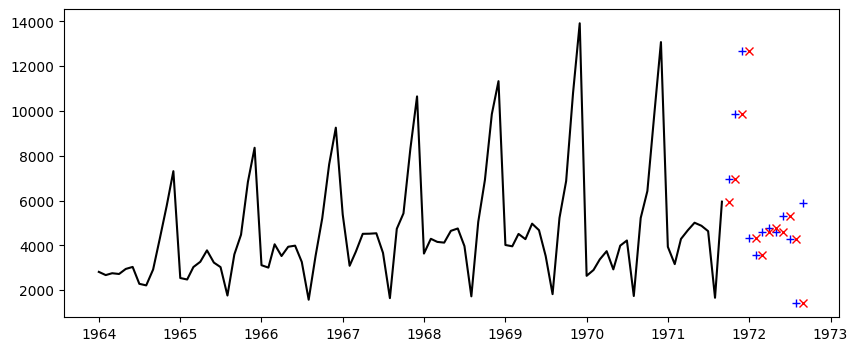

In [36]:
#Modelo ingenuo
history = [x for x in train['Sales'].values]
predictions = list()

for i in range(len(test['Sales'])):
  yhat = history[-1]
  predictions.append(yhat)

  # Observaciones-registros reales:
  obs = test.iloc[i]['Sales']  
  history.append(obs) 
  print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))


# RMSE
rmse = np.sqrt(mean_squared_error(test['Sales'].values, predictions))
print('\nError-Modelo-Naive: RMSE: %.3f' % rmse)



fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(train['Sales'], '-k')  # Datos de entrenamiento
ax = plt.plot(test['Sales'], '+b')    # Datos de prueba reales
ax = plt.plot(test.index, predictions, 'xr')  # Predicciones del modelo ingenuo para el último año

### RMSE=3,135.480

## Modelo ARIMA

/tmp/ipykernel_2460/2526427747.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  decomposition = seasonal_decompose(train['Sales'].resample('M').mean(), model='multiplicative')


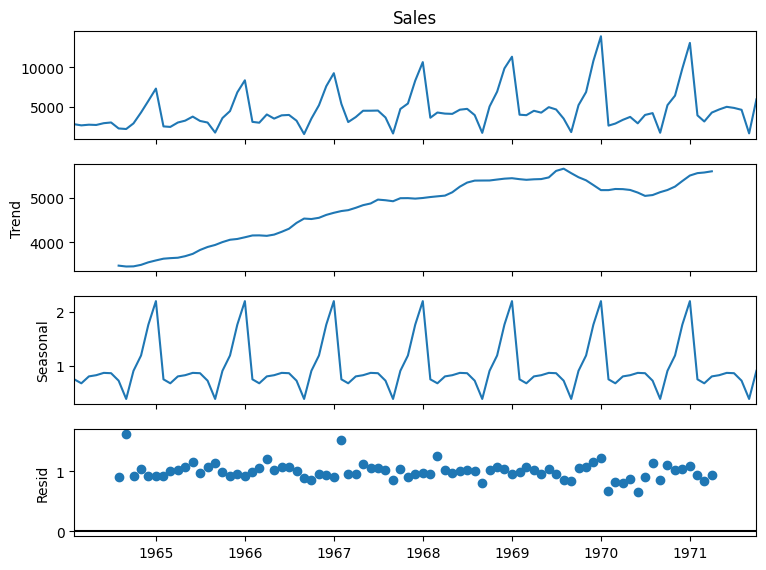

/tmp/ipykernel_2460/2526427747.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fig2 = month_plot(train['Sales'].resample('M').mean(), ylabel='Sales Monthly')


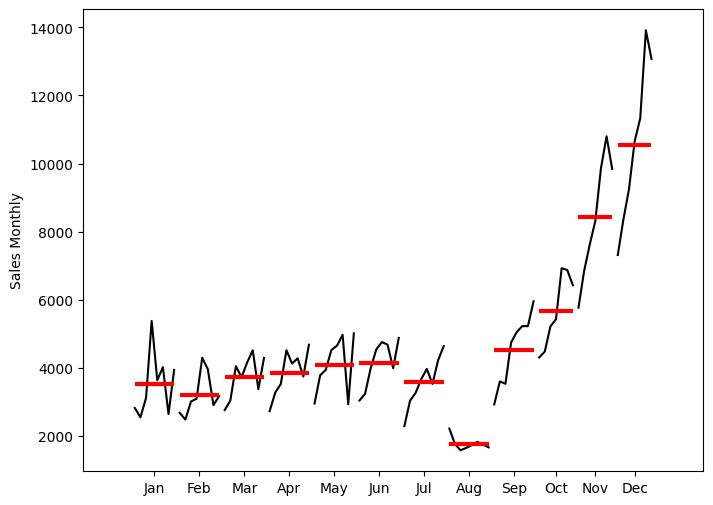

/tmp/ipykernel_2460/2526427747.py:14: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  fig3 = quarter_plot(train['Sales'].resample('Q').mean(), ylabel='Sales trim')


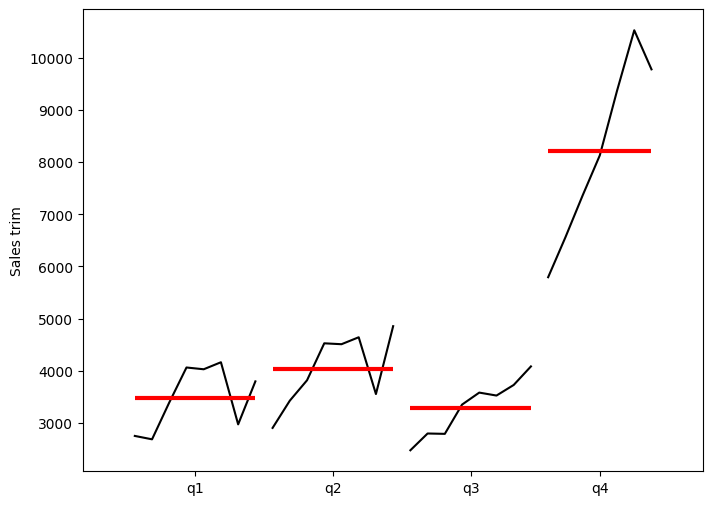

In [46]:
# Gráficos de descomposición estacional:
decomposition = seasonal_decompose(train['Sales'].resample('M').mean(), model='multiplicative') 
fig = decomposition.plot()
fig.set_size_inches(8,6)
plt.show()


# Gráfica para detección de estacionalidad mensual:
fig2 = month_plot(train['Sales'].resample('M').mean(), ylabel='Sales Monthly')
fig2.set_size_inches(8,6)
plt.show()

# Si queremos graficar y detectar estacionalidad trimestral:
fig3 = quarter_plot(train['Sales'].resample('Q').mean(), ylabel='Sales trim')
fig3.set_size_inches(8,6)
plt.show()

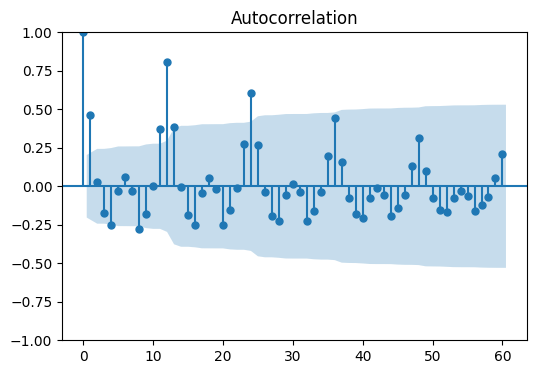

In [ ]:
# Gráfico de Autocorrelación (ACF: Auto-Correlation-Function)
fig,ax = plt.subplots(figsize = (6,4))
plot_acf(train['Sales'], lags=60, ax=ax)   
plt.show()  #al parecer es un desfase anual (12 meses)

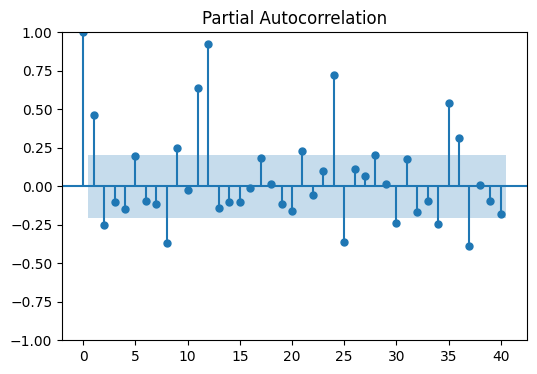

In [51]:
# Gráfico de Autocorrelación Parcial (PACF):
fig, ax = plt.subplots(figsize = (6,4))
plot_pacf(train['Sales'], lags = 40, ax = ax, method="ols")   # ols: regression of time series on lags of it an on constant. predetrminado method="ywm"
plt.show()

Cada 12 meses marca un punto de alta correlación, de modo que esl comportamiento es anual y tiene replicas cada 12 meses siendo año a año cada vez menos influyente, **tanto para PACF como para ACF**

In [56]:
from statsmodels.tsa.arima.model import ARIMA

# Lo primero es para quitar la estacionalidad y transformar un problema
# de tipo no-estacionario (SARIMA) en uno estacionario (ARIMA):

# Diferencia de datos consecutivos en el tiempo
# y podemos ahora usar ARIMA:
def difference(dataset, interval=1):
  diff = list()

  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)

  return np.array(diff)

# Invierte las diferencias anteriores, es decir, nos regresa la estacionalidad:
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]



# Definamos la siguiente lista de registros de pasajeros en el tiempo:
history = [x for x in train.loc[:,'Sales'].values]   # train-ndarray : columna solo con los registros de pasajeros "y".
predictions = list()   # Para incluir las predicciones que vaya generando el modelo.

for i in range(len(test['Sales'])):
  #
  months_in_year = 12
  diff = difference(history, months_in_year)    # diff-list: lista de los datos de diferencias para transformar SARIMA en ARIMA.

  # Generamos el modelo.
  model = ARIMA(diff, order=(3,0,13),) # Si aplicamos diff, entonces d=0 es aplicable.
  model_fit = model.fit(method_kwargs={'maxiter':300})

  yhat = model_fit.forecast()[0]   # prediccions (yhat) de cada registro, es un solo número flotante.
  yhat = inverse_difference(history, yhat, months_in_year)    
  predictions.append(yhat)  # predictions-list : lista que se va incrementando al ir agregando cada predicción nueva.

  # Observaciones-reales:
  obs = test.iloc[i]['Sales']   #  cada dato es un flotante.
  history.append(obs)  

  print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))

# Error RMSE:
rmse = np.sqrt(mean_squared_error(test['Sales'].values, predictions))
print('\nError-Modelo-ARIMA: RMSE: %.3f' % rmse)


>Esperado-real = 6981, Predicción = 6657.953
>Esperado-real = 9851, Predicción = 9758.450
>Esperado-real = 12670, Predicción = 13712.700
>Esperado-real = 4348, Predicción = 4079.799
>Esperado-real = 3564, Predicción = 3727.102
>Esperado-real = 4577, Predicción = 4256.352
>Esperado-real = 4788, Predicción = 5061.580
>Esperado-real = 4618, Predicción = 5301.321
>Esperado-real = 5312, Predicción = 5044.929
>Esperado-real = 4298, Predicción = 4981.020
>Esperado-real = 1413, Predicción = 1691.481
>Esperado-real = 5877, Predicción = 5846.853

Error-Modelo-ARIMA: RMSE: 461.842


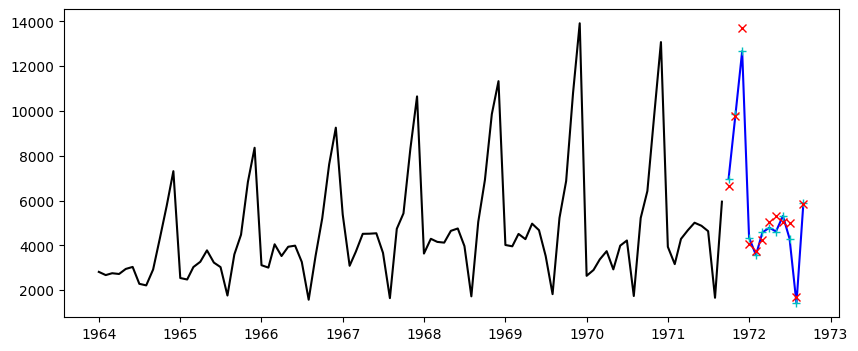

In [55]:
# Veamos su gráfico:
fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(train['Sales'], '-k')
ax = plt.plot(test['Sales'], '-b')
ax = plt.plot(test['Sales'], '+c')
ax = plt.plot(test.index, predictions, 'xr')

### RMSE=461.842

## Facebook Prophet

In [85]:
train = df.iloc[0:-12,:]
test = df.iloc[-12:,:] 

train.columns = ['y']
train['ds']=train.index
test.columns=['y']
test['ds']=test.index

/tmp/ipykernel_2460/3422599832.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ds']=train.index
/tmp/ipykernel_2460/3422599832.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds']=test.index


In [86]:
# Aplicamos el modelo Facebook-Prophet a nuestros datos:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=True,
                changepoint_prior_scale=10.,   # Controla la flexibilidad de la componente Trend, mayor valor mayores fluctuaciones.
                seasonality_prior_scale=18)    # Controla la estacionalidad, mayor el valor, mayor flexibilidad en la estacionalidad.
model.fit(train)

01:47:06 - cmdstanpy - INFO - Chain [1] start processing


01:47:06 - cmdstanpy - INFO - Chain [1] done processing


In [87]:
# Calculamos el error RMSE:

pred_FP = model.predict(test)['yhat']
rmse = np.sqrt(mean_squared_error(test['y'], pred_FP))
print('\nError-Modelo-FacebookProphet: RMSE: %.3f' % rmse)


Error-Modelo-FacebookProphet: RMSE: 1322.266


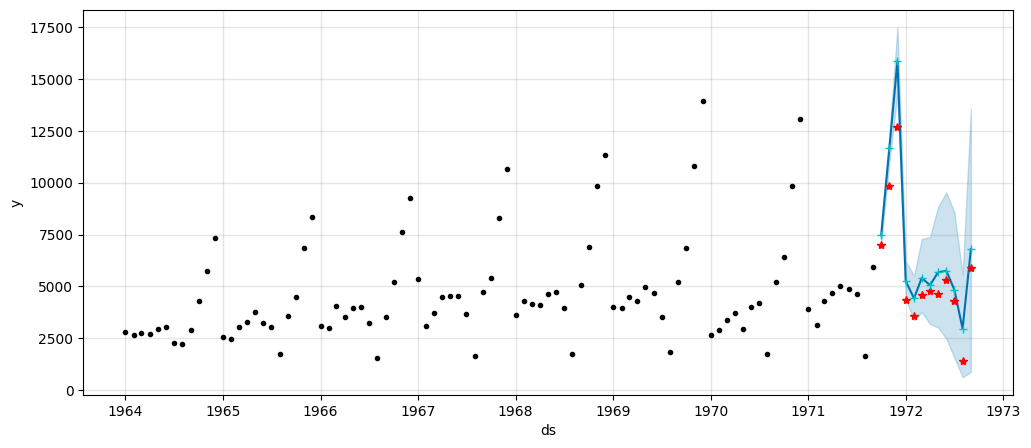

In [89]:
# La librería misma nos permite obtener las predicciones con las cotas mínima
# y máxima, además de su gráfica, como se muestra a continuación:

forecast = model.predict(test)

fig, ax = plt.subplots(figsize=(12, 5))
model.plot(forecast, ax=ax)               # Las predicciones se muestran con la línea continua, junto con su región de variabilidad de la predicción.
ax = plt.plot(test['ds'], test['y'], '*r')   # Agregamos los datos de prueba (Test) con puntos rojos, para observar la diferencia.
ax = plt.plot(test['ds'], forecast['yhat'], '+c')    # Valores reales.

### RMSE=1,322.266

## LSTM

In [91]:
# Definimos una función para crear secuencias de tiempo con la ventada de tiempo que consideremos adecuada.

def creamos_secuencias(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])  # Ventana en este ejercicio de 12 meses de manera continua
        y.append(data[i])  # y el siguiente mes a predecir, dados los 12 anteriores.
    return np.array(X), np.array(y)

In [ ]:
# Tamaño de la ventana, para este ejercicio y con las autocorrelaciones consideramos 12 meses:
window_size = 12

# Creamos las secuencias de entrenamiento
X, y = creamos_secuencias(df[['Sales']].values, window_size)

print(X.shape)  # verifiquemos que el formato es el requerido por la CNN.

(93, 12, 1)


In [96]:
# Dividimos los datos en Entrenamiento y Prueba:
split = int(0.85 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(X_train.shape)   # (secuencias, tamaño_secuencia, variables)
print(X_test.shape)    # Test no necesariamente tiene que ser de 12 secuencias, pero sí al menos incluir 12.

(79, 12, 1)
(14, 12, 1)


In [116]:
# Construimos un modelo secuencial relativamente simple basado en LSTMs:
model = Sequential()
model.add(LSTM(500,  # total de neuronas de la capa LSTM
               return_sequences=True, # para que siga manteniendo el formato de 3 dimensiones.
               activation='relu',
               recurrent_activation='sigmoid'
               ))  # Capa LSTM
model.add(LSTM(500, return_sequences=False, activation='relu'))
model.add(Dense(1))  # Capa de salida

# Compilamos el modelo
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()],   #  despliega RMSE
              )

# y llevamos a cabo el entrenamiento con los cunjuntos de entrenamiento y prueba:
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/150


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - loss: 29528060.0000 - root_mean_squared_error: 5432.2568 - val_loss: 30773806.0000 - val_root_mean_squared_error: 5547.4146
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 22286804.0000 - root_mean_squared_error: 4717.3794 - val_loss: 13133045.0000 - val_root_mean_squared_error: 3623.9543
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 6606654.5000 - root_mean_squared_error: 2560.5964 - val_loss: 9529878.0000 - val_root_mean_squared_error: 3087.0500
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 5897153.0000 - root_mean_squared_error: 2421.2646 - val_loss: 7468500.0000 - val_root_mean_squared_error: 2732.8557
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 4724264.5000 - root_mean_squared_error: 2170.4985 - val_loss: 7445547.5000 - val_root_mean_squared_error: 2728.6531
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 5472632.0000 - root_mean_squared_error: 2337.1624 - val_loss: 4612219.0000

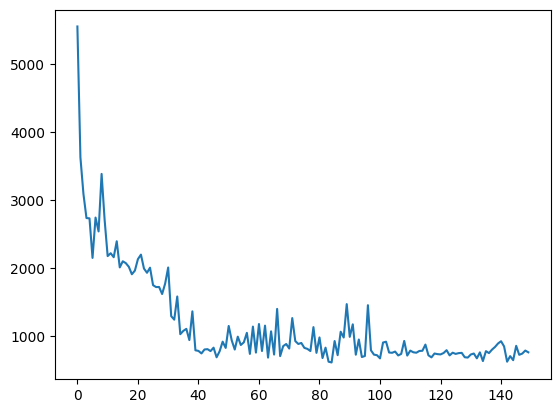

In [117]:
plt.plot(history.history['val_root_mean_squared_error'])

In [118]:
pred_LSTM = model.predict(X_test[-12:])
y_test_real = y_test[-12:].reshape(-1, 1)

# Calculamos el RMSE en la escala original de los datos:
rmse = np.sqrt(mean_squared_error(y_test_real, pred_LSTM))
print('\nError-Modelo-LSTM: RMSE: %.3f' % rmse) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step

Error-Modelo-LSTM: RMSE: 683.875


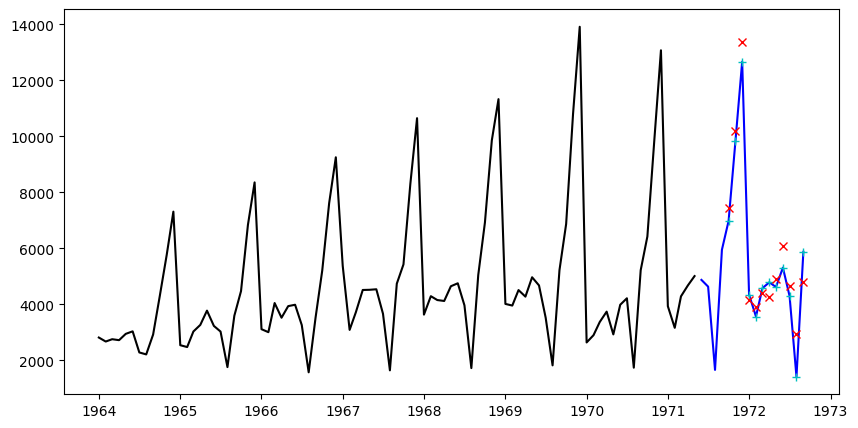

In [119]:
df['ds']=df.index
df['y']=df['Sales']
fig, ax = plt.subplots(figsize=(10, 5))
ax = plt.plot(df['ds'][0:int(0.85 * len(df))], df['y'][0:int(0.85 * len(df))], '-k')
ax = plt.plot(df['ds'][int(0.85 * len(df)):], df['y'][int(0.85 * len(df)):], '-b')
ax = plt.plot(df['ds'][-12:], df['y'][-12:], '+c')
ax = plt.plot(df['ds'][-12:], pred_LSTM, 'xr')  # Predicciones puntuales del modelo del último año 1960.

### RMSE=683.875

## **<<< Fin de la Actividad de la Semana - Pronósticos y Series de Tiempo >>>**